In [ ]:
pip install pandas numpy matplotlib wordcloud seaborn nltk scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download required NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# 1. Load and Prepare Data
file_path = "/content/Untitled spreadsheet (1).xlsx"
data = pd.read_excel(file_path)


In [ ]:
data.head()

,rating,text,text.1
0,5.0,Good quality light weight and price see a good...,"अच्छी गुणवत्ता, हल्के वजन और कीमत से अच्छा उत्..."
1,2.0,Not meet expectations,अपेक्षाओं पर खरा नहीं उतरना
2,5.0,The product compared to others in its category...,यह उत्पाद अपनी श्रेणी के अन्य उत्पादों की तुलन...
3,4.0,worth the cost,लागत के लायक
4,5.0,Niceee!!!,बहुत बढ़िया!!!


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51154 entries, 0 to 51153
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  51152 non-null  float64
 1   text    51151 non-null  object 
 2   text.1  51154 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
data.isna().sum()

,0
rating,2
text,3
text.1,0


In [ ]:
data.dropna(inplace=True)


In [ ]:
data.isna().sum()

,0
rating,0
text,0
text.1,0


In [ ]:
data.shape[0]

51151

In [ ]:
# Create the 'Sentiment' column based on 'reviews.rating'
data['Sentiment'] = data['rating'].map({1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'})

# Display the updated DataFrame
data.head()

,rating,text,text.1,Sentiment
0,5.0,Good quality light weight and price see a good...,"अच्छी गुणवत्ता, हल्के वजन और कीमत से अच्छा उत्...",Positive
1,2.0,Not meet expectations,अपेक्षाओं पर खरा नहीं उतरना,Negative
2,5.0,The product compared to others in its category...,यह उत्पाद अपनी श्रेणी के अन्य उत्पादों की तुलन...,Positive
3,4.0,worth the cost,लागत के लायक,Positive
4,5.0,Niceee!!!,बहुत बढ़िया!!!,Positive


In [ ]:
data = data.drop('rating', axis=1)

In [ ]:
# Map the 'Sentiment' column to numeric values
data['Sentiment'] = data['Sentiment'].map({
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
})

# Display the first few rows of the updated DataFrame
data.head()

,text,text.1,Sentiment
0,Good quality light weight and price see a good...,"अच्छी गुणवत्ता, हल्के वजन और कीमत से अच्छा उत्...",2
1,Not meet expectations,अपेक्षाओं पर खरा नहीं उतरना,0
2,The product compared to others in its category...,यह उत्पाद अपनी श्रेणी के अन्य उत्पादों की तुलन...,2
3,worth the cost,लागत के लायक,2
4,Niceee!!!,बहुत बढ़िया!!!,2


In [ ]:
data.value_counts('Sentiment')

,count
Sentiment,
2,37345
0,9324
1,4482


In [ ]:
# Resample the data to balance the classes (optional but recommended for imbalanced datasets)
from sklearn.utils import resample

# Separate majority and minority classes
negative_reviews = data[data['Sentiment'] == 0]
positive_reviews = data[data['Sentiment'] == 2]
neutral_reviews = data[data['Sentiment'] == 1]

# Upsample minority classes
negative_upsampled = resample(negative_reviews, replace=True, n_samples=len(positive_reviews), random_state=42)
neutral_upsampled = resample(neutral_reviews, replace=True, n_samples=len(positive_reviews), random_state=42)

# Combine upsampled minority classes with the majority class
data = pd.concat([positive_reviews, negative_upsampled, neutral_upsampled])

# Check the class distribution after upsampling
print(data['Sentiment'].value_counts())

Sentiment
2    37345
0    37345
1    37345
Name: count, dtype: int64


In [ ]:


import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup


# Read stopwords from the file
with open('hindi_stopwords.txt', 'r', encoding='utf-8') as f:
    hindi_stopwords = set(f.read().splitlines())

# Additional Hindi stopwords (common ones not in NLTK)
additional_hindi_stopwords = {
    'का', 'के', 'की', 'है', 'था', 'थी', 'थे', 'हैं', 'में',
    'पर', 'को', 'से', 'ने', 'और', 'या', 'एक', 'एवं', 'यह', 'उनके'
}
hindi_stopwords.update(additional_hindi_stopwords)

# Preprocessing function for Hindi text
def preprocess_hindi_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert text to lowercase
    text = text.lower()

    # Remove URLs and mentions
    text = re.sub(r'@\w+|https?://\S+', '', text)

    # Remove special characters, numbers, and punctuation (retain Hindi characters and spaces)
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)

    # Tokenize words
    tokens = word_tokenize(text)

    # Remove stopwords and very short tokens
    tokens = [token for token in tokens if token not in hindi_stopwords and len(token) > 2]

    # Rejoin cleaned tokens into a single text
    return ' '.join(tokens)

# Apply preprocessing to the Hindi text column
# Replace 'reviews.text' with the actual column name containing Hindi reviews
data['text.1'] = data['text.1'].apply(preprocess_hindi_text)

# Display the original vs. cleaned text
data['text.1'].head()


,text.1
0,अच्छी गुणवत्ता हल्के वजन कीमत अच्छा उत्पाद दिखता
2,उत्पाद श्रेणी अन्य उत्पादों तुलना सस्ता है। प्...
3,लागत लायक
4,बढ़िया
7,अच्छा बटुआ


In [ ]:
data.shape

(112035, 3)

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      7518
           1       0.52      0.53      0.53      7375
           2       0.62      0.67      0.65      7514

    accuracy                           0.61     22407
   macro avg       0.61      0.61      0.61     22407
weighted avg       0.61      0.61      0.61     22407

Accuracy score : 0.6069085553621636


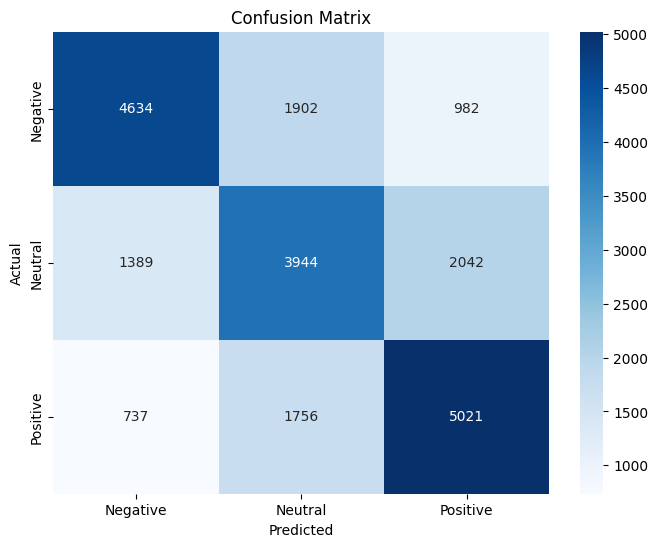

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text.1'])
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy score : {accuracy_score(y_test,y_pred)}")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.74      0.70      7518
     Neutral       0.57      0.47      0.52      7375
    Positive       0.65      0.69      0.67      7514

    accuracy                           0.64     22407
   macro avg       0.63      0.64      0.63     22407
weighted avg       0.63      0.64      0.63     22407

Accuracy Score: 0.636140491810595


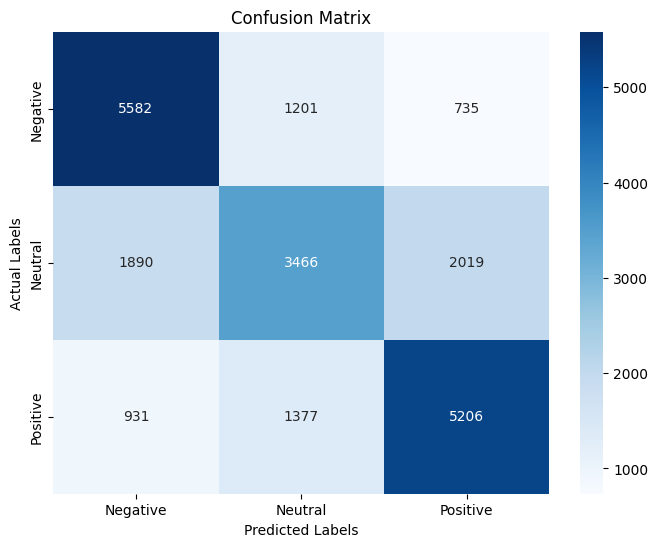

In [ ]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text.1'])
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.81      0.75      7518
     Neutral       0.64      0.61      0.62      7375
    Positive       0.76      0.67      0.71      7514

    accuracy                           0.70     22407
   macro avg       0.70      0.70      0.70     22407
weighted avg       0.70      0.70      0.70     22407

Accuracy Score: 0.6971928415227384


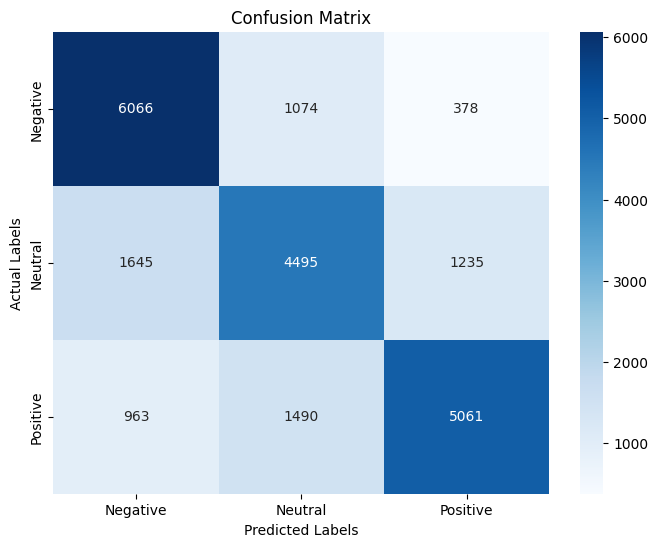

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text.1'])
y = data['Sentiment']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)  # Use multiclass evaluation metric
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pickle

# Save the model
with open('hindi_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

# Save the TF-IDF vectorizer
with open('hindi_tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [ ]:
# prompt: generate a prediction for the model . input is from user

import pickle
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# Load the saved model and vectorizer
with open('hindi_model.pkl', 'rb') as file:
    model = pickle.load(file)

with open('hindi_tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Read stopwords from the file
with open('hindi_stopwords.txt', 'r', encoding='utf-8') as f:
    hindi_stopwords = set(f.read().splitlines())

# Additional Hindi stopwords
additional_hindi_stopwords = {
    'का', 'के', 'की', 'है', 'था', 'थी', 'थे', 'हैं', 'में',
    'पर', 'को', 'से', 'ने', 'और', 'या', 'एक', 'एवं', 'यह', 'उनके'
}
hindi_stopwords.update(additional_hindi_stopwords)

# Preprocessing function (same as in training)
def preprocess_hindi_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r'@\w+|https?://\S+', '', text)
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in hindi_stopwords and len(token) > 2]
    return ' '.join(tokens)

def predict_sentiment(text):
    # Preprocess the input text
    preprocessed_text = preprocess_hindi_text(text)

    # Transform the text using the loaded vectorizer
    text_vectorized = vectorizer.transform([preprocessed_text])

    # Make a prediction
    prediction = model.predict(text_vectorized)[0]

    # Map the numeric prediction back to sentiment label
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = sentiment_mapping[prediction]
    return sentiment


# Get input from the user
user_input = input("Enter text in Hindi: ")


# Predict the sentiment
predicted_sentiment = predict_sentiment(user_input)

# Print the predicted sentiment
print(f"Predicted sentiment: {predicted_sentiment}")

Enter text in Hindi: बहुत बढ़िया!!!
Predicted sentiment: Positive
